In [4]:
from spd.experiments.mlp.models import SparseMLP
from spd.configs import Config
from spd.utils.general_utils import load_config
import torch

config = load_config("../experiments/mlp/arithmetic_config.yaml", config_model=Config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target_model = SparseMLP()
target_model.load_state_dict(torch.load("../experiments/mlp/arithmetic_model.pth", map_location=device))
target_model = target_model.to(device)
target_model.eval()

SparseMLP(
  (fc1): Linear(in_features=16, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=20, bias=False)
  (fc3): Linear(in_features=20, out_features=20, bias=False)
)

spd-f9rg854i

In [5]:
from spd.models.component_model import ComponentModel
import torch

state_dict = torch.load("/root/spd_cache/runs/spd-35zpu6u3/model_30000.pth", map_location="cpu")

target_model.requires_grad_(False)
component_model = ComponentModel(
    target_model=target_model,
    target_module_patterns=config.target_module_patterns,
    C=config.C,
    gate_type=config.gate_type,
    gate_hidden_dims=config.gate_hidden_dims,
    pretrained_model_output_attr=config.pretrained_model_output_attr,
    identity_module_patterns=config.identity_module_patterns,
)

component_model.load_state_dict(state_dict)
component_model.eval()


fc1
fc2
fc3


ComponentModel(
  (patched_model): SparseMLP(
    (fc1): ComponentsOrModule(
      (original): Linear(in_features=16, out_features=20, bias=False)
      (components): LinearComponents()
    )
    (fc2): ComponentsOrModule(
      (original): Linear(in_features=20, out_features=20, bias=False)
      (components): LinearComponents()
    )
    (fc3): ComponentsOrModule(
      (original): Linear(in_features=20, out_features=20, bias=False)
      (components): LinearComponents()
    )
  )
  (_gates): ModuleDict(
    (fc1): GateMLPs(
      (layers): Sequential(
        (0): ParallelLinear()
        (1): GELU(approximate='none')
        (2): ParallelLinear()
      )
    )
    (fc2): GateMLPs(
      (layers): Sequential(
        (0): ParallelLinear()
        (1): GELU(approximate='none')
        (2): ParallelLinear()
      )
    )
    (fc3): GateMLPs(
      (layers): Sequential(
        (0): ParallelLinear()
        (1): GELU(approximate='none')
        (2): ParallelLinear()
      )
    )
  )
)

In [6]:
components = {
    "fc1": {
        "U": component_model.patched_model.fc1.components.U,
        "V": component_model.patched_model.fc1.components.V,
    },
    "fc2": {
        "U": component_model.patched_model.fc2.components.U,
        "V": component_model.patched_model.fc2.components.V,
    },
    "fc3": {
        "U": component_model.patched_model.fc3.components.U,
        "V": component_model.patched_model.fc3.components.V,
    },
}

In [7]:
target_direction = torch.zeros(20)
target_direction[0] = 1

read_norms = []
write_norms = []
cos_sims = []

for c in range(100):
    write_direction = components["fc3"]["U"][c, :]
    read_direction = components["fc3"]["V"][:, c]
    cos_sim = torch.nn.functional.cosine_similarity(write_direction, target_direction, dim=0) * read_direction.norm().item() * write_direction.norm().item()
    cos_sims.append(cos_sim.item())
    read_norms.append(read_direction.norm().item())
    write_norms.append(write_direction.norm().item())
# print(cos_sims)

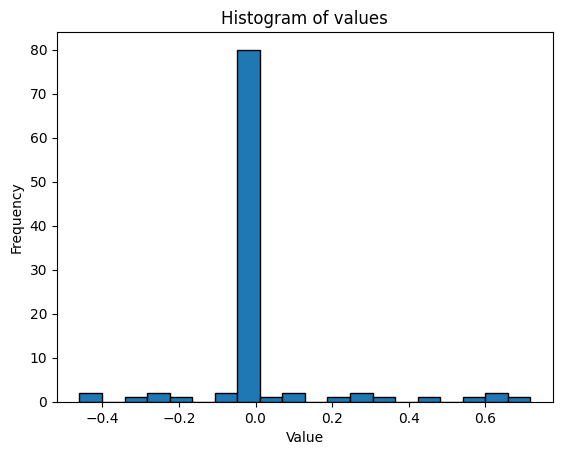

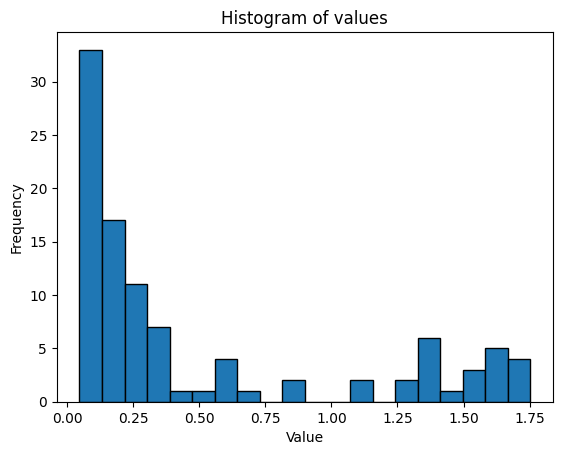

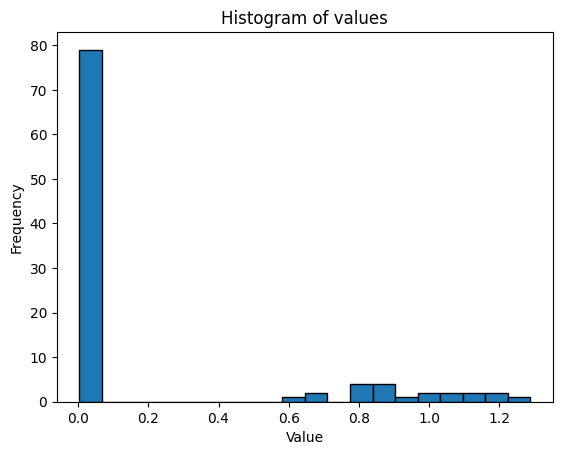

In [8]:
import matplotlib.pyplot as plt

plt.hist(cos_sims, bins=20, edgecolor="black")  # bins controls granularity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of values")
plt.show()

plt.hist(read_norms, bins=20, edgecolor="black")  # bins controls granularity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of values")
plt.show()

plt.hist(write_norms, bins=20, edgecolor="black")  # bins controls granularity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of values")
plt.show()

In [30]:
def backchain_one_layer(components, layer_name, target_directions, C):

    Us = []
    Vs = []

    for c in range(C):
        write_direction = components[layer_name]["U"][c, :]
        read_direction = components[layer_name]["V"][:, c]

        for t in range(len(target_directions)):
            target_direction = target_directions[t]
            cos_sim = torch.nn.functional.cosine_similarity(write_direction, target_direction, dim=0)
            if abs(cos_sim * read_direction.norm().item() * write_direction.norm().item()) >= 0.6:
                Us.append(write_direction)
                Vs.append(read_direction)
                break
    
    print(len(Us))
    U_out = torch.stack(Us)
    V_out = torch.stack(Vs)
    return U_out, V_out



In [31]:
target_dir = torch.zeros(20)
target_dir[16] = 1

target_directions = [target_dir]

Us3, Vs3 = backchain_one_layer(components, "fc3", target_directions, 100)

Us2, Vs2 = backchain_one_layer(components, "fc2", Vs3, 100)

Us1, Vs1 = backchain_one_layer(components, "fc1", Vs2, 100)



4
4
1


In [32]:
print(Vs1.sum(dim=0))

tensor([ 6.4118e-04, -6.1925e-04,  1.0553e-03,  6.3939e-04, -9.0068e-04,
         8.2106e-01, -7.3935e-04,  1.1309e-04, -1.1631e+00, -1.6728e+00,
        -1.2041e+00,  2.8131e-04, -3.8282e-04,  1.1035e-03,  2.2932e-03,
        -1.7369e-04], grad_fn=<SumBackward1>)


In [23]:
# Assemble the weights for fc1 from the U and V matrices
import einops

weights_1 = einops.einsum(Us1, Vs1, "c u, c v -> u v")

weights_2 = einops.einsum(Us2, Vs2, "c u, c v -> u v")

weights_3 = einops.einsum(Us3, Vs3, "c u, c v -> u v")

print(weights_3)


tensor([[-8.9258e-02,  4.2824e-02,  4.2092e-02,  2.1737e-01, -7.8084e-02,
          1.0527e-03,  5.8030e-02,  2.3486e-02, -9.1233e-02, -1.8212e-01,
         -8.2669e-02, -1.8304e-02, -1.7744e-01, -2.0692e-01,  1.1641e-01,
         -1.8485e-02,  1.9228e-01,  1.0560e-01,  1.5242e-02,  7.2334e-02],
        [-4.9276e-02, -3.8352e-02, -7.4258e-02, -1.5436e-01, -1.1631e-01,
          5.5064e-02,  3.9077e-02, -1.1666e-01, -5.0087e-02,  2.9634e-02,
         -6.2737e-03,  9.2088e-03,  5.7097e-02,  1.0697e-01,  2.8249e-02,
         -1.4952e-01, -6.5823e-02,  2.2073e-02,  5.3832e-03,  9.6492e-02],
        [-1.3566e-01,  3.1092e-03, -3.2368e-02,  6.2541e-02, -1.9152e-01,
          5.6158e-02,  9.4561e-02, -9.4728e-02, -1.4054e-01, -1.5162e-01,
         -8.7181e-02, -9.4154e-03, -1.2015e-01, -1.0016e-01,  1.4379e-01,
         -1.6669e-01,  1.2628e-01,  1.2644e-01,  1.9073e-02,  1.7150e-01],
        [-1.6487e-02, -1.1786e-02,  2.6201e-02,  5.0939e-02, -2.1201e-02,
         -1.7389e-02,  2.3828e-03, 